<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Convolutional Neural Network with Small Images</h1> 

<h2>Table of Contents</h2>
<p>In this lab, we will use a Convolutional Neural Network to classify handwritten digits from the MNIST database. We will reshape the images to make them faster to process </p>

<ul>
<li><a href="#Makeup_Data">Get Some Data</a></li>
<li><a href="#CNN">Convolutional Neural Network</a></li>
<li><a href="#Train">Define Softmax, Criterion function, Optimizer and Train the Model</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong> 14 min to train model </p>

<hr>

<h2>Preparation</h2>

In [1]:
# Import the libraries we need to use in this lab
import time
START_TIME = time.time()

# Using the following line code to install the torchvision library
# !conda install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [2]:
print(torch.cuda.is_available())
DEV = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(DEV)

True
cuda:0


Define the function *plot_channels* to plot out the kernel parameters of each channel. 

In [3]:
def plot_channels(W):
    n_out = W.shape[0] # number of output channels 
    n_in  = W.shape[1] # number of input channels
    w_min, w_max = W.min().item(), W.max().item()
    
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_ix, in_ix = 0, 0 
    # plot outputs as rows,  inputs as columns 
    for ax in axes.flat:
        if in_ix > n_in - 1:
            out_ix += 1
            in_ix = 0
              
        ax.imshow(W[out_ix, in_ix, :, :].cpu(), vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_ix += 1
    #
    plt.show()

Define the function *plot_parameters* to plot out the kernel parameters of each channel with multiple outputs. 

In [4]:
def plot_parameters(W, num_rows=1, name="", ix=0):
    W = W.data[:, ix, :, :].cpu() # <-- 
    n_filters = W.shape[0]
    w_min, w_max = W.min().item(), W.max().item()
   
    fig, axes = plt.subplots(num_rows, n_filters // num_rows)
    fig.subplots_adjust(hspace=0.4)

    for jx, ax in enumerate(axes.flat):
        if jx < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(jx + 1))

            # Plot the image.
            ax.imshow(W[jx, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    #
    plt.suptitle(name, fontsize=10)    
    plt.show()

Define the function *plot_activation* to plot out the activations of the Convolutional layers  

In [5]:
def plot_activations(img, num_rows=1, name=""):
    img = img[0, :, :, :].cpu().detach().numpy() # <--- 
    num_activ = img.shape[0]
    print(num_activ)
    A_min, A_max = img.min().item(), img.max().item()
    if num_activ == 1:
        ## Plot the image.
        plt.imshow(img[0, :], vmin=A_min, vmax=A_max, cmap='seismic')
    else:
        fig, axes = plt.subplots(num_rows, num_activ // num_rows)
        fig.subplots_adjust(hspace = 0.4)
        for ix, ax in enumerate(axes.flat):
            if ix < num_activ:
                ## Set the label for the sub-plot.
                ax.set_xlabel( "activation:{0}".format(ix + 1))
                ## Plot the image.
                ax.imshow(img[ix, :], vmin=A_min, vmax=A_max, cmap='seismic')
                ax.set_xticks([])
                ax.set_yticks([])
    plt.show()

Define the function <code>show_data</code> to plot out data samples as images.

In [6]:
def show_data(data_sample, img_sz):
    plt.imshow(data_sample[0].cpu().numpy().reshape(img_sz, img_sz), cmap='gray') # <--- 
    plt.title('y = '+ str(data_sample[1]))
    plt.show()

<h2 id="Makeup_Data">Get the Data</h2> 

we create a transform to resize the image and convert it to a tensor .

In [7]:
IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

Load the training dataset by setting the parameters <code>train </code> to <code>True</code>. We use the transform defined above.

In [8]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

Load the validation dataset by setting the parameters train  <code>False</code>.

In [9]:
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

We can see the data type is long.

In [10]:
train_dataset[0][1] #.type()  # Show the data type for each element in dataset

5

Each element in the rectangular tensor corresponds to a number representing a pixel intensity as demonstrated by the following image.

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.2.1imagenet.png" width="550" alt="MNIST data image">

Print out the fourth label 

In [11]:
# The label for the fourth data element
train_dataset[3][1]

1

Plot the fourth sample 

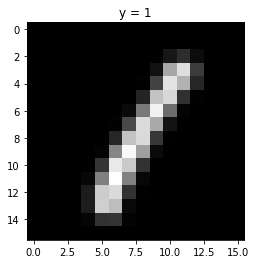

In [12]:
# The image for the fourth data element
show_data(train_dataset[3], img_sz=IMAGE_SIZE)

The fourth sample is a "1".

<!--Empty Space for separating topics-->

### Build a Convolutional Neural Network Class

Build a Convolutional Network class with:
- 2 Convolutional layers and 
- 1 fully connected layer. 

Pre-determine the size of the final output matrix.  
The parameters in the constructor are the number of output channels for the first and second layer.

In [13]:
class CNN(nn.Module):
    ## Contructor
    def __init__(self, out_1=16, out_2=32):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        #
        self.fc1 = nn.Linear(out_2*4*4, 10) # 256, 10 outputs
    
    ## Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        #
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        # 
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs in each steps
    def activations(self, x):
        ## outputs activation - this is not necessary just for fun 
        x = x.to(DEV) # <--- 
        z1  = self.cnn1(x)
        a1  = torch.relu(z1)
        out = self.maxpool1(a1)
        #
        z2  = self.cnn2(out)
        a2  = torch.relu(z2)
        out = self.maxpool2(a2)
        #
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out

### Define the Convolutional Neural Network Classifier

Model, criterion function, optimizer and train the Model.  
There are 16 output channels for the first layer, and 32 output channels for the second layer.

In [14]:
## Create the model object using CNN class
model = CNN(out_1=16, out_2=32)
model.to(DEV)
model

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

Plot the model parameters for the kernels before training the kernels. The kernels are initialized randomly.

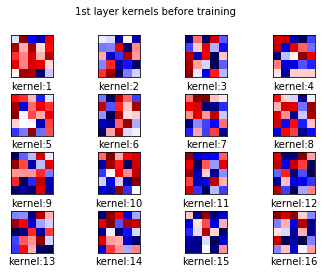

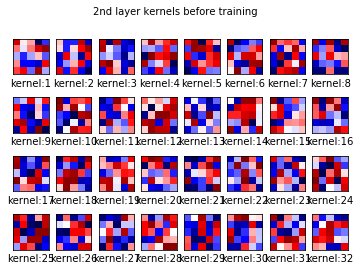

In [15]:
plot_parameters(model.state_dict()['cnn1.weight'], num_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], num_rows=4, name='2nd layer kernels before training' )

Define the loss function, the optimizer and the dataset loader 

In [16]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=5000)

Train the model and determine validation accuracy technically test accuracy **(This may take a long time)**

In [17]:
# n_epochs = 3

def train_model(n_epochs=3, n_test=len(validation_dataset)):
    cost_list, acc_list = [], []
    for epoch in range(n_epochs):
        cost = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to(DEV), y.to(DEV)
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            cost += loss.data
        
        cost_list.append(cost)
        correct = 0
        ## Perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            x_test, y_test = x_test.to(DEV), y_test.to(DEV)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            
        acc = correct / n_test
        acc_list.append(acc)
    return cost_list, acc_list
#
#
start = time.time()
cost_list, acc_list = train_model(n_epochs=10)

print("elapsed time (s): ", time.time() - start)

elapsed time (s):  57.4170823097229


<!--Empty Space for separating topics-->

<h2 id="Result">Analyze Results</h2> 

Plot the loss and accuracy on the validation data:

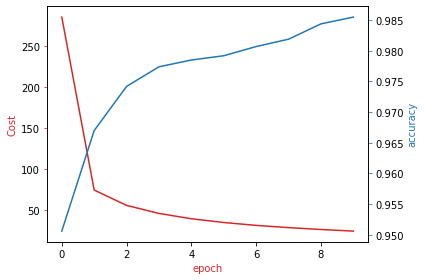

In [18]:
## Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot(acc_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

View the results of the parameters for the Convolutional layers 

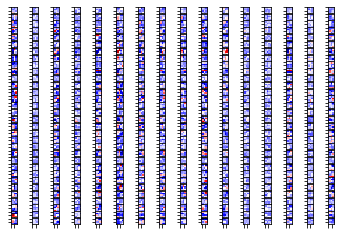

In [19]:
## Plot the channels
plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

Consider the following sample 

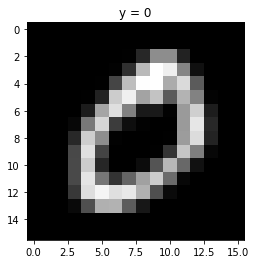

In [20]:
## Show the second image
show_data(train_dataset[1], img_sz=IMAGE_SIZE)

Determine the activations 

In [21]:
## Use the CNN activations class to see the steps
out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Plot out the first set of activations 

16


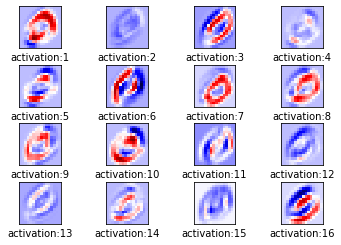

In [22]:
## Plot the outputs after the first CNN
plot_activations(out[0], num_rows=4, name="Output after the 1st CNN")

The image below is the result after applying the relu activation function 

16


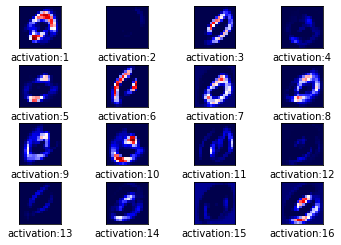

In [23]:
## Plot the outputs after the first Relu activation
plot_activations(out[1], num_rows=4, name="Output after the 1st Relu")

The image below is the result of the activation map after the second output layer.

32


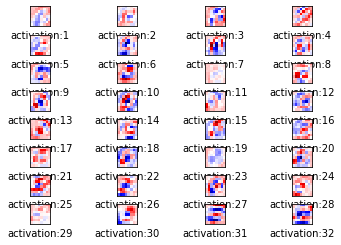

In [24]:
## Plot the outputs after the second CNN
plot_activations(out[2], num_rows=32 // 4, name="Output after the 2nd CNN")

The image below is the result of the activation map after applying the second relu  

32


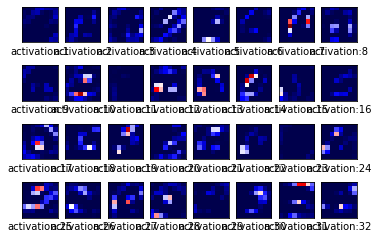

In [25]:
## Plot the outputs after the second Relu activation
plot_activations(out[3], num_rows=4, name="Output after the 2nd Relu")

We can  see the result for the third sample 

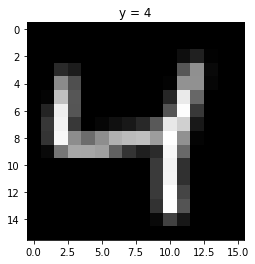

In [26]:
## Show the third image
show_data(train_dataset[2], img_sz=IMAGE_SIZE)

In [27]:
## Use the CNN activations class to see the steps
out = model.activations(train_dataset[2][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

16


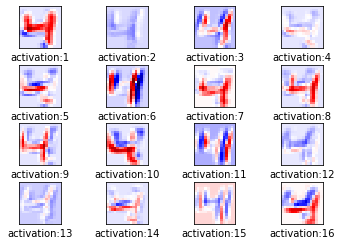

In [28]:
## Plot the outputs after the first CNN
plot_activations(out[0], num_rows=4, name="Output after the 1st CNN")

16


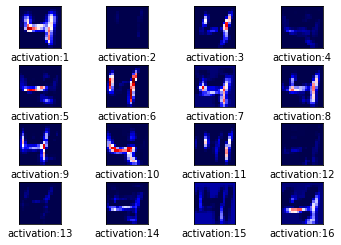

In [29]:
## Plot the outputs after the first Relu
plot_activations(out[1], num_rows=4, name="Output after the 1st Relu")

32


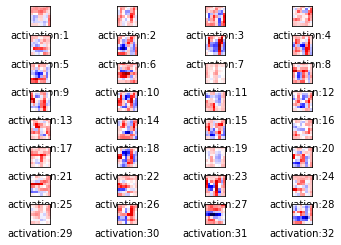

In [30]:
## Plot the outputs after the second CNN
plot_activations(out[2], num_rows=32 // 4, name="Output after the 2nd CNN")

32


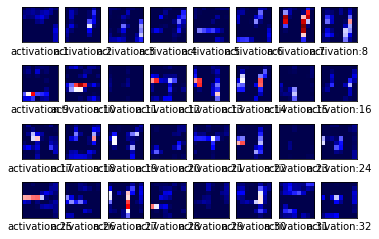

In [31]:
## Plot the outputs after the second Relu
plot_activations(out[3], num_rows=4, name="Output after the 2nd Relu")

Plot the first five mis-classified samples:

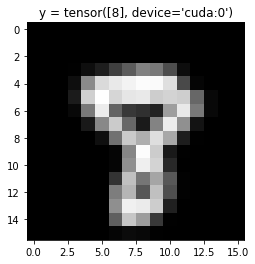

yhat:  tensor([3], device='cuda:0')


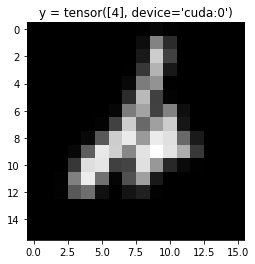

yhat:  tensor([2], device='cuda:0')


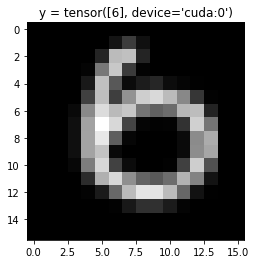

yhat:  tensor([0], device='cuda:0')


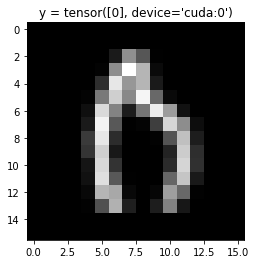

yhat:  tensor([5], device='cuda:0')


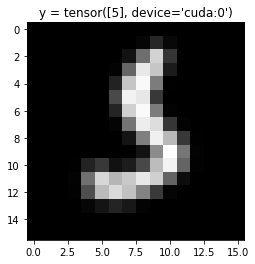

yhat:  tensor([3], device='cuda:0')


In [32]:
## Plot the mis-classified samples
count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    x, y = x.to(DEV), y.to(DEV)
    z = model(x)
    _, yhat = torch.max(z, 1)
    
    if yhat != y:
        show_data((x, y), img_sz=IMAGE_SIZE)
        plt.show()
        print("yhat: ",yhat)
        count += 1
        if count >= 5: break  

In [33]:
## Done
print("elapsed time (s): ", time.time() - START_TIME)  
# gpu:   92.28433895111084 - 10 epochs
# cpu:  199.087082862854   - 10 epochs

elapsed time (s):  92.28433895111084


<!--Empty Space for separating topics-->

<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom" />
</a>

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>

Thanks to Magnus <a href="http://www.hvass-labs.org/">Erik Hvass Pedersen</a> whose tutorials helped me understand convolutional Neural Network

<hr>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.